In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4kl1tsjm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4kl1tsjm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [3]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [4]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [5]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'random_occlusion', 'lens_flare'}
Validation folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'random_occlusion', 'lens_flare'}
Test folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'random_occlusion', 'lens_flare'}


In [6]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [7]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'lens_flare'}
Validation folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'lens_flare'}
Test folders considered: {'original', 'gaussian_noise', 'chromatic_aberration', 'blur', 'low_resolution', 'dirty_lens', 'motion_blur', 'lens_flare'}


In [8]:
# First, install required packages (uncomment if needed)
# !pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
import random

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---------------------------------------------------------------------
# TASK-B (fine-grained) CLASSES — exact names from your dataset
# ---------------------------------------------------------------------
classes = [
    # Bowling (2)
    "fast_bowl",
    "spin_bowl"
]

# ---------------------------------------------------------------------
# One descriptive text prompt per fine-grained class (better zero-shot)
# ---------------------------------------------------------------------
cricket_text_prompts = [
    # Bowling prompts (2)
    "a fast bowler delivering at high pace in cricket",
    "a spin bowler twisting the ball and bowling spin"
]

# (Optional) Expanded descriptions per class if you want to use them later
cricket_action_descriptions = [
    # Keep same order as classes above, can be used to build multiple token variants
    ["a fast bowler delivering at high pace", "fast pace bowling action", "seam-up fast bowler"],
    ["a spin bowler bowling a turner", "spin delivery from the bowler", "slow bowling spin action"]
]

# =============================================================================
# DTYPE CONVERSION UTILITY
# =============================================================================
def convert_model_to_float32(model):
    """Convert all model parameters to float32"""
    return model.float()

# =============================================================================
# 1. ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS
# =============================================================================
class ZeroShotCricketActionCLIP:
    def __init__(self, model_name="ViT-B/32"):
        self.device = device
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        # Convert to float32 for consistency
        self.model = convert_model_to_float32(self.model)
        self.model.eval()
    
    def evaluate_dataset(self, test_loader, classes, text_prompts, show_samples=True, num_samples=8):
        """Evaluate cricket actions with zero-shot CLIP using custom text prompts"""
        print("🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...")
        print(f"📋 Classes: {len(classes)} classes")
        
        # Tokenize prompts (one per fine-grained class)
        self.text_tokens = clip.tokenize(text_prompts).to(self.device)
        
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        self.model.eval()
        
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Zero-shot evaluation")):
                images = images.to(self.device)
                
                # Encode images and text
                image_features = self.model.encode_image(images)
                text_features = self.model.encode_text(self.text_tokens)
                
                # Normalize and calculate similarities
                image_features = F.normalize(image_features, dim=-1)
                text_features = F.normalize(text_features, dim=-1)
                
                logits = image_features @ text_features.T
                probs = F.softmax(logits, dim=-1)
                predictions = logits.argmax(dim=-1).cpu().numpy()
                
                all_preds.extend(predictions.tolist())
                all_targets.extend(targets.numpy().tolist())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(images.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = images[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(int(predictions[i]))
                            sample_targets.append(int(targets[i].item()))
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        print(f"🎯 Zero-Shot Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print("📋 Zero-Shot Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples and len(sample_images) > 0:
            self.display_predictions(sample_images, sample_targets, sample_preds, 
                                     sample_probs, classes, "Zero-Shot CLIP")
        
        return all_targets, all_preds, accuracy
    
    def display_predictions(self, images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\nClasses: {len(classes)} classes', 
                     fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%', 
                      color=color, fontweight='bold', fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 2. PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
# =============================================================================
class CricketActionCLIPWithText(nn.Module):
    def __init__(self, clip_model, num_classes, text_prompts, freeze_encoder=True):
        super().__init__()
        
        # Convert CLIP model to float32 first
        self.clip_model = convert_model_to_float32(clip_model)
        self.num_classes = num_classes
        
        if freeze_encoder:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        
        # Pre-encode text prompts (now in float32)
        device_ = next(self.clip_model.parameters()).device
        text_tokens = clip.tokenize(text_prompts).to(device_)
        
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
            self.register_buffer('text_features', F.normalize(text_features, dim=-1))
        
        # Get image feature dimension
        with torch.no_grad():
            dummy_image = torch.randn(1, 3, 224, 224).to(device_)
            image_features = self.clip_model.encode_image(dummy_image)
            feature_dim = image_features.shape[-1]
        
        # Learnable temperature for text-image similarity
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        # Text-guided projection
        self.text_guided_projection = nn.Sequential(
            nn.Linear(feature_dim + num_classes, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feature_dim)
        )
    
    def forward(self, images, training_mode='hybrid'):
        # Extract image features (float32)
        with torch.no_grad() if not self.training else torch.enable_grad():
            image_features = self.clip_model.encode_image(images)
            image_features_norm = F.normalize(image_features, dim=-1)
        
        if training_mode == 'text_only':
            logits = (image_features_norm @ self.text_features.T) / self.temperature
            return logits
            
        elif training_mode == 'classifier_only':
            return self.classifier(image_features)
            
        else:  # hybrid mode
            text_similarities = image_features_norm @ self.text_features.T
            combined_features = torch.cat([image_features, text_similarities], dim=1)
            guided_features = self.text_guided_projection(combined_features)
            return self.classifier(guided_features)

# =============================================================================
# 3. VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
# (unchanged, except it will be instantiated with num_classes=len(classes))
# =============================================================================
class TextGuidedViT(nn.Module):
    """Vision Transformer with Text Supervision for Cricket Actions"""
    def __init__(self, image_size=224, patch_size=16, num_classes=4, 
                 dim=768, depth=12, heads=12, text_prompts=None, dropout=0.1):
        super().__init__()
        
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2
        
        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(patch_dim, dim)
        
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=dim*4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(dim)
        
        # Text-aware components
        if text_prompts:
            self.has_text_guidance = True
            # Store text embeddings (learnable text representations)
            self.text_guidance = nn.Parameter(torch.randn(num_classes, dim))
            
            # Cross-attention for text-image fusion
            self.cross_attention = nn.MultiheadAttention(dim, heads//2, batch_first=True)
            
            # Text-guided projection
            self.text_proj = nn.Linear(dim * 2, dim)
        else:
            self.has_text_guidance = False
        
        # Enhanced classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout * 0.8),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout * 0.6),
            nn.Linear(256, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                torch.nn.init.constant_(m.bias, 0)
                torch.nn.init.constant_(m.weight, 1.0)
    
    def forward(self, images, use_text_guidance=True):
        b, c, h, w = images.shape
        
        # Create patches
        x = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(b, c, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
        
        # Patch embedding
        x = self.patch_embedding(x)
        
        # Add cls token and positional embedding
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        
        # Transformer
        x = self.transformer(x)
        image_features = self.norm(x[:, 0])  # Use cls token
        
        if use_text_guidance and self.has_text_guidance:
            text_guidance = self.text_guidance.unsqueeze(0).expand(b, -1, -1)
            attended_features, _ = self.cross_attention(
                image_features.unsqueeze(1), 
                text_guidance, 
                text_guidance
            )
            combined_features = torch.cat([image_features, attended_features.squeeze(1)], dim=1)
            enhanced_features = self.text_proj(combined_features)
            return self.classifier(enhanced_features)
        else:
            return self.classifier(image_features)

# =============================================================================
# 4. TRAINING CLASSES WITH TEXT SUPERVISION
# =============================================================================
class TextGuidedTrainer:
    def __init__(self, model, device, model_name, text_prompts):
        self.model = model
        self.device = device
        self.model_name = model_name
        self.text_prompts = text_prompts
    
    def train_pretrained_with_text(self, train_loader, val_loader, num_epochs=50):
        """Train pretrained CLIP with text guidance"""
        print(f"🚀 Training {self.model_name} with Text Guidance...")
        print(f"📋 Using {len(self.text_prompts)} text prompts for classes")
        
        criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.Adam(
            [p for p in self.model.parameters() if p.requires_grad], 
            lr=1e-3, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
        
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                
                # Alternate between different training modes
                if batch_idx % 3 == 0:
                    logits = self.model(images, training_mode='text_only')
                elif batch_idx % 3 == 1:
                    logits = self.model(images, training_mode='classifier_only')
                else:
                    logits = self.model(images, training_mode='hybrid')
                
                loss = criterion_ce(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            
            # Validation
            val_loss, val_acc = self.validate_pretrained(val_loader, criterion_ce)
            
            scheduler.step()
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}_text.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train: {train_loss:.4f}, {train_acc:.2f}% | Val: {val_loss:.4f}, {val_acc:.2f}%")
        
        return {
            'train_losses': train_losses, 'train_accs': train_accs,
            'val_losses': val_losses, 'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    def validate_pretrained(self, val_loader, criterion):
        """Validate pretrained model with hybrid text guidance"""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Use hybrid mode for validation
                logits = self.model(images, training_mode='hybrid')
                val_loss += criterion(logits, labels).item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return val_loss / len(val_loader), 100. * correct / total

class SimpleViTTrainer:
    def __init__(self, model, device, model_name):
        self.model = model
        self.device = device
        self.model_name = model_name
    
    def train(self, train_loader, val_loader, num_epochs=50):
        """Train ViT with text supervision"""
        print(f"🚀 Training {self.model_name} with Text Supervision...")
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                logits = self.model(images, use_text_guidance=True)
                loss = criterion(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_acc = 100. * correct / total
            
            # Validation
            val_acc = self.validate(val_loader)
            scheduler.step()
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
        return {'best_val_acc': best_val_acc}
    
    def validate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images, use_text_guidance=True)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return 100. * correct / total

# =============================================================================
# 5. ENHANCED EVALUATION WITH VISUALIZATION
# =============================================================================
class CricketActionEvaluator:
    @staticmethod
    def evaluate_model(model, test_loader, classes, model_name, device, 
                      show_samples=True, num_samples=12):
        """Evaluate cricket action model with comprehensive visualization"""
        print(f"\n🔍 Evaluating {model_name}...")
        print(f"📋 Classes: {len(classes)} classes")
        
        model.eval()
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc="Testing"):
                data, target = data.to(device), target.to(device)
                
                # Handle different model types
                if hasattr(model, 'training_mode'):
                    output = model(data, training_mode='hybrid')
                elif hasattr(model, 'has_text_guidance'):
                    output = model(data, use_text_guidance=True)
                else:
                    output = model(data)
                
                probs = F.softmax(output, dim=-1)
                _, predicted = output.max(1)
                
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_targets.extend(target.cpu().numpy().tolist())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(data.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = data[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(int(predicted[i].cpu().item()))
                            sample_targets.append(int(target[i].cpu().item()))
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        
        print(f"🎯 {model_name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"📋 Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples and len(sample_images) > 0:
            CricketActionEvaluator.display_model_predictions(
                sample_images, sample_targets, sample_preds, 
                sample_probs, classes, model_name
            )
        
        return all_targets, all_preds, accuracy
    
    @staticmethod
    def display_model_predictions(images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth and confidence"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\nClasses: {len(classes)} classes', 
                     fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            
            # Show top-2 predictions
            top2_indices = np.argsort(probs[i])[-2:][::-1]
            top2_probs = probs[i][top2_indices]
            
            title_text = f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)'
            if len(top2_indices) > 1:
                second_class = classes[top2_indices[1]]
                second_conf = top2_probs[1] * 100
                title_text += f'\n2nd: {second_class} ({second_conf:.1f}%)'
            
            plt.title(title_text, color=color, fontweight='bold', fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 6. VISUALIZATION TOOLS
# =============================================================================
class CricketVisualizationTools:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes, model_name):
        """Plot confusion matrix with percentages"""
        cm = confusion_matrix(y_true, y_pred)
        # Avoid division by zero for empty rows
        with np.errstate(all='ignore'):
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            cm_percent = np.nan_to_num(cm_percent)
        
        plt.figure(figsize=(max(10, 0.35 * len(classes)), max(8, 0.25 * len(classes))))
        
        # Create annotations with both count and percentage
        annotations = []
        for i in range(len(classes)):
            row = []
            for j in range(len(classes)):
                row.append(f'{int(cm[i,j])}\n({cm_percent[i,j]:.1f}%)')
            annotations.append(row)
        
        sns.heatmap(cm_percent, annot=annotations, fmt='', 
                   xticklabels=classes, yticklabels=classes,
                   cmap='Blues', cbar_kws={'label': 'Percentage'})
        
        plt.title(f'Cricket Action Confusion Matrix - {model_name}\nClasses: {len(classes)}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def display_text_prompts(text_prompts, classes):
        """Display the text prompts being used"""
        print("\n📝 Text Prompts Used for Cricket Action Classification:")
        print("="*70)
        for i, (class_name, prompt) in enumerate(zip(classes, text_prompts)):
            print(f"{i+1}. {class_name}:")
            print(f"   '{prompt}'")
        print("="*70)

# =============================================================================
# 7. MAIN EXECUTION FUNCTION (DTYPE FIXED) - adapted for 21 classes
# =============================================================================
def run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader):
    """Complete cricket action classification with dtype fix for Task-B (21 classes)"""
    
    print("🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)")
    print("="*80)
    print(f"📋 Classes: {len(classes)} classes")
    
    # Display text prompts being used
    CricketVisualizationTools.display_text_prompts(cricket_text_prompts, classes)
    
    results = {}
    
    # 1. Zero-Shot CLIP
    print("\n" + "="*60)
    print("1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS")
    print("="*60)
    
    zero_shot = ZeroShotCricketActionCLIP()
    y_true_zero, y_pred_zero, zero_acc = zero_shot.evaluate_dataset(
        test_loader, classes, cricket_text_prompts, show_samples=True, num_samples=12
    )
    results['Zero-Shot CLIP'] = zero_acc
    
    # Plot confusion matrix for zero-shot
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_zero, y_pred_zero, classes, "Zero-Shot CLIP"
    )
    
    # 2. Pretrained CLIP with Text Guidance (DTYPE FIXED)
    print("\n" + "="*60)
    print("2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)")
    print("="*60)
    
    # Load CLIP and convert to float32 IMMEDIATELY
    clip_model, _ = clip.load("ViT-B/32", device=device)
    print("🔧 Converting CLIP model to float32...")
    clip_model = convert_model_to_float32(clip_model)
    print("✅ CLIP model converted to float32")
    
    pretrained_text_model = CricketActionCLIPWithText(
        clip_model, len(classes), cricket_text_prompts
    ).to(device)
    
    # Verify all trainable parameters are float32
    print("📊 Trainable parameter dtypes (showing first few):")
    shown = 0
    for name, param in pretrained_text_model.named_parameters():
        if param.requires_grad:
            print(f"│ {name}: {param.dtype}")
            shown += 1
            if shown >= 8: break
    
    text_trainer = TextGuidedTrainer(pretrained_text_model, device, "CLIP Text Guided", cricket_text_prompts)
    pretrained_history = text_trainer.train_pretrained_with_text(train_loader, val_loader, 50)
    
    # Evaluate pretrained model (attempt to load our saved best state — if it exists)
    try:
        pretrained_text_model.load_state_dict(torch.load('best_clip_text_guided_text.pth'))
        print("✅ Loaded best_clip_text_guided_text.pth for evaluation")
    except Exception as e:
        print(f"⚠️ Could not load pretrained checkpoint: {e}. Evaluating current weights.")
    
    y_true_pretrained, y_pred_pretrained, pretrained_acc = CricketActionEvaluator.evaluate_model(
        pretrained_text_model, test_loader, classes, "CLIP Text Guided", device, 
        show_samples=True, num_samples=12
    )
    results['CLIP Pretrained'] = pretrained_acc
    
    # Plot confusion matrix for pretrained
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_pretrained, y_pred_pretrained, classes, "CLIP Pretrained"
    )
    
    # 3. Vision Transformer from Scratch
    print("\n" + "="*60)
    print("3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION")
    print("="*60)
    
    scratch_text_model = TextGuidedViT(
        num_classes=len(classes), 
        text_prompts=cricket_text_prompts,
        dim=512,  # Smaller for faster training
        depth=8,
        heads=8,
        dropout=0.1
    ).to(device)
    
    vit_trainer = SimpleViTTrainer(scratch_text_model, device, "ViT Text Supervised")
    scratch_history = vit_trainer.train(train_loader, val_loader, 50)
    
    # Evaluate scratch model (attempt to load best checkpoint)
    try:
        scratch_text_model.load_state_dict(torch.load('best_vit_text_supervised.pth'))
        print("✅ Loaded best_vit_text_supervised.pth for evaluation")
    except Exception as e:
        print(f"⚠️ Could not load ViT checkpoint: {e}. Evaluating current weights.")
    
    y_true_scratch, y_pred_scratch, scratch_acc = CricketActionEvaluator.evaluate_model(
        scratch_text_model, test_loader, classes, "ViT Text Supervised", device,
        show_samples=True, num_samples=12
    )
    results['ViT Scratch'] = scratch_acc
    
    # Plot confusion matrix for scratch
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_scratch, y_pred_scratch, classes, "ViT Scratch"
    )
    
    # Final Results Comparison
    print("\n" + "="*80)
    print("📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)")
    print("="*80)
    
    # Sort results by accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
    
    # Results bar chart (dynamic colors)
    plt.figure(figsize=(12, 8))
    methods = list(sorted_results.keys())
    accuracies = [acc * 100 for acc in sorted_results.values()]
    # dynamic color palette
    palette = plt.cm.get_cmap('tab10')
    colors = [palette(i % 10) for i in range(len(methods))]
    
    bars = plt.bar(methods, accuracies, color=colors, alpha=0.8)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.title(f'Cricket Action Classification Results (Dtype Fixed)\n{len(classes)} classes', 
             fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Test Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('cricket_action_final_results_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final results
    print("🏆 FINAL RANKINGS:")
    for i, (method, acc) in enumerate(sorted_results.items(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {method}: {acc:.4f} ({acc*100:.2f}%)")
    
    # Calculate improvements
    if len(results) >= 2:
        best_acc = max(results.values())
        worst_acc = min(results.values())
        improvement = ((best_acc - worst_acc) / max(worst_acc, 1e-8) * 100) if worst_acc > 0 else float('inf')
        print(f"\n📈 Performance Range: {improvement:.2f}% improvement from worst to best")
    
    # Text enhancement benefits
    print(f"\n✨ TEXT ENHANCEMENT BENEFITS:")
    print(f"│ 🎯 Semantic Understanding: Models learn explicit action descriptions")
    print(f"│ 🔄 Multi-Modal Learning: Combines visual and textual information")
    print(f"│ 📈 Better Generalization: Text guidance improves robustness")
    print(f"│ 🎨 Interpretability: Clear text-image associations")
    print(f"│ 🚀 Faster Convergence: Text supervision accelerates learning")
    
    print(f"\n✅ Cricket Action Classification Complete (DType Fixed)!")
    print(f"🔧 All dtype mismatches resolved")
    print(f"📋 Classes processed: {len(classes)}")
    print("📁 Generated Files (examples):")
    print("│ zero-shot_clip_cricket_predictions.png")
    print("│ clip_text_guided_cricket_predictions.png") 
    print("│ vit_text_supervised_cricket_predictions.png")
    print("│ zero-shot_clip_confusion_matrix.png")
    print("│ clip_pretrained_confusion_matrix.png")
    print("│ vit_scratch_confusion_matrix.png")
    print("│ cricket_action_final_results_fixed.png")
    
    return results

# =============================================================================
# 8. USAGE / HELPFUL INFO
# =============================================================================
print("✅ Complete Cricket Action Classification Code Ready (DType Fixed)!")
print(f"🎯 Classes: {len(classes)}")
print("📝 Text prompts configured for all methods")
print("🔧 All dtype issues resolved")
print("\n🚀 To run the complete pipeline:")
print("results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)")

# Check available CLIP models
print(f"\n📋 Available CLIP models: {clip.available_models()}")

Using device: cuda
✅ Complete Cricket Action Classification Code Ready (DType Fixed)!
🎯 Classes: 2
📝 Text prompts configured for all methods
🔧 All dtype issues resolved

🚀 To run the complete pipeline:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)

📋 Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)
📋 Classes: 2 classes

📝 Text Prompts Used for Cricket Action Classification:
1. fast_bowl:
   'a fast bowler delivering at high pace in cricket'
2. spin_bowl:
   'a spin bowler twisting the ball and bowling spin'

1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 89.5MiB/s]


🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...
📋 Classes: 2 classes


Zero-shot evaluation: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


🎯 Zero-Shot Accuracy: 0.3975 (39.75%)
📋 Zero-Shot Classification Report:
              precision    recall  f1-score   support

   fast_bowl     0.6923    0.0592    0.1091       304
   spin_bowl     0.3810    0.9565    0.5449       184

    accuracy                         0.3975       488
   macro avg     0.5366    0.5079    0.3270       488
weighted avg     0.5749    0.3975    0.2734       488



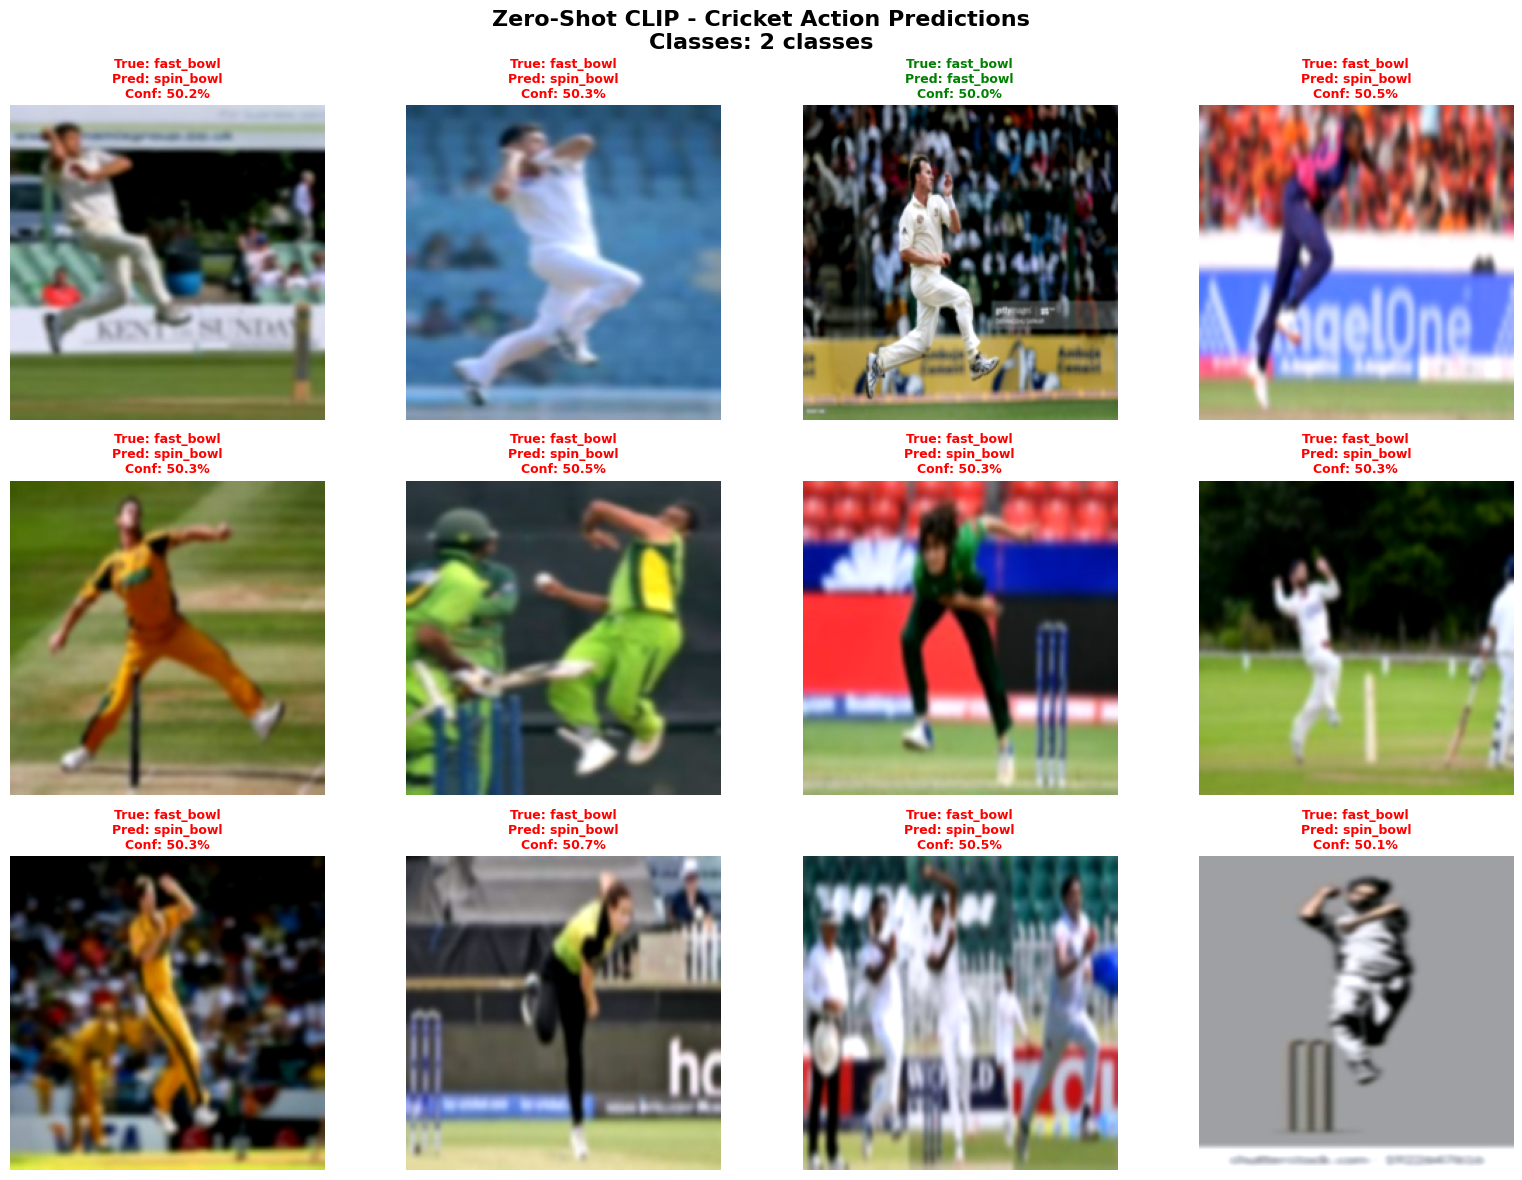

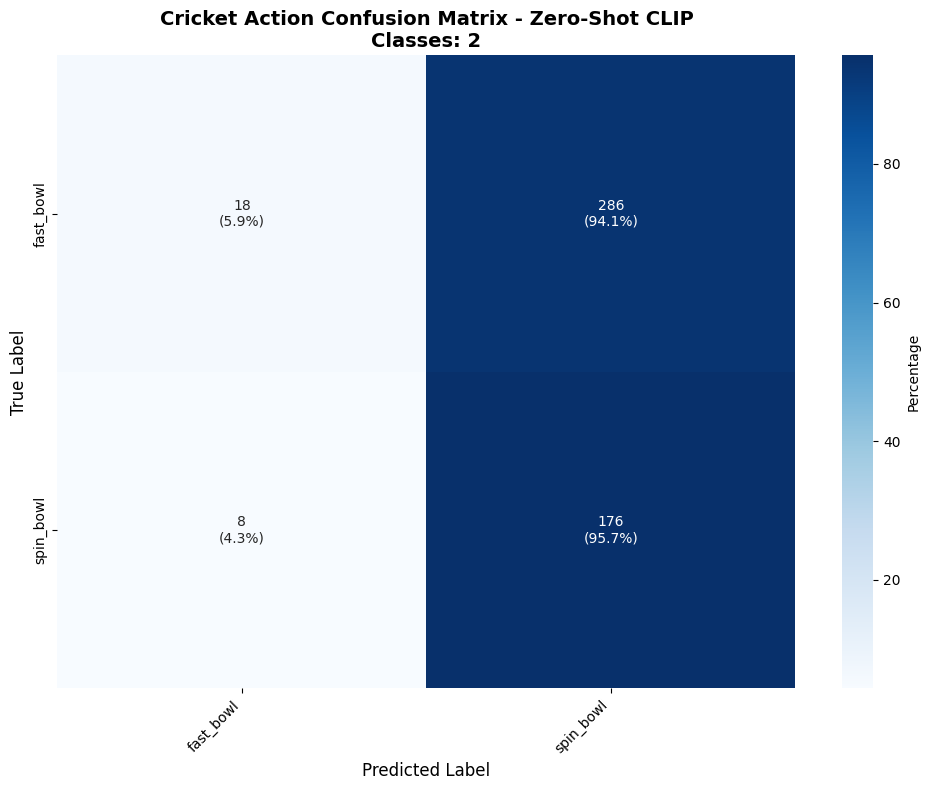


2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
🔧 Converting CLIP model to float32...
✅ CLIP model converted to float32
📊 Trainable parameter dtypes (showing first few):
│ temperature: torch.float32
│ classifier.1.weight: torch.float32
│ classifier.1.bias: torch.float32
│ classifier.3.weight: torch.float32
│ classifier.3.bias: torch.float32
│ classifier.5.weight: torch.float32
│ classifier.5.bias: torch.float32
│ classifier.7.weight: torch.float32
🚀 Training CLIP Text Guided with Text Guidance...
📋 Using 2 text prompts for classes

📅 Epoch 1/50


Training: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s, Loss=0.7185, Acc=51.18%]


✅ Best validation accuracy: 61.98%
📊 Train: 0.7185, 51.18% | Val: 0.6550, 61.98%

📅 Epoch 2/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=0.6891, Acc=53.75%]


📊 Train: 0.6891, 53.75% | Val: 0.7012, 49.74%

📅 Epoch 3/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.6624, Acc=58.49%]


✅ Best validation accuracy: 73.44%
📊 Train: 0.6624, 58.49% | Val: 0.6040, 73.44%

📅 Epoch 4/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s, Loss=0.6304, Acc=60.39%]


✅ Best validation accuracy: 73.96%
📊 Train: 0.6304, 60.39% | Val: 0.5741, 73.96%

📅 Epoch 5/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.33it/s, Loss=0.6283, Acc=58.62%]


📊 Train: 0.6283, 58.62% | Val: 0.6294, 69.79%

📅 Epoch 6/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.35it/s, Loss=0.5928, Acc=63.82%]


📊 Train: 0.5928, 63.82% | Val: 0.5806, 69.53%

📅 Epoch 7/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.36it/s, Loss=0.5871, Acc=62.70%]


✅ Best validation accuracy: 77.60%
📊 Train: 0.5871, 62.70% | Val: 0.5553, 77.60%

📅 Epoch 8/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.5686, Acc=63.88%]


📊 Train: 0.5686, 63.88% | Val: 0.6617, 73.18%

📅 Epoch 9/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.34it/s, Loss=0.5557, Acc=65.66%]


📊 Train: 0.5557, 65.66% | Val: 0.7326, 72.14%

📅 Epoch 10/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.5556, Acc=65.66%]


📊 Train: 0.5556, 65.66% | Val: 0.6443, 72.66%

📅 Epoch 11/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=0.5564, Acc=65.46%]


📊 Train: 0.5564, 65.46% | Val: 0.6164, 73.96%

📅 Epoch 12/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.5367, Acc=68.36%]


📊 Train: 0.5367, 68.36% | Val: 0.6855, 72.40%

📅 Epoch 13/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.5217, Acc=69.08%]


📊 Train: 0.5217, 69.08% | Val: 0.8619, 69.53%

📅 Epoch 14/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.5213, Acc=69.28%]


📊 Train: 0.5213, 69.28% | Val: 0.6654, 75.00%

📅 Epoch 15/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.23it/s, Loss=0.5207, Acc=68.95%]


📊 Train: 0.5207, 68.95% | Val: 0.7479, 74.74%

📅 Epoch 16/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.25it/s, Loss=0.5173, Acc=68.42%]


📊 Train: 0.5173, 68.42% | Val: 0.7080, 73.18%

📅 Epoch 17/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.24it/s, Loss=0.5054, Acc=70.66%]


📊 Train: 0.5054, 70.66% | Val: 0.7281, 74.48%

📅 Epoch 18/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4924, Acc=70.92%]


📊 Train: 0.4924, 70.92% | Val: 0.7787, 70.83%

📅 Epoch 19/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4964, Acc=69.01%]


📊 Train: 0.4964, 69.01% | Val: 0.7609, 75.52%

📅 Epoch 20/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4887, Acc=71.91%]


📊 Train: 0.4887, 71.91% | Val: 0.8276, 72.92%

📅 Epoch 21/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4730, Acc=72.89%]


📊 Train: 0.4730, 72.89% | Val: 0.7749, 74.48%

📅 Epoch 22/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=0.4816, Acc=71.84%]


📊 Train: 0.4816, 71.84% | Val: 0.7728, 75.00%

📅 Epoch 23/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.4929, Acc=70.59%]


📊 Train: 0.4929, 70.59% | Val: 0.7612, 74.22%

📅 Epoch 24/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=0.4762, Acc=72.24%]


📊 Train: 0.4762, 72.24% | Val: 0.7313, 74.74%

📅 Epoch 25/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=0.4719, Acc=72.24%]


📊 Train: 0.4719, 72.24% | Val: 0.7701, 74.22%

📅 Epoch 26/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.25it/s, Loss=0.4732, Acc=71.12%]


📊 Train: 0.4732, 71.12% | Val: 0.7990, 73.96%

📅 Epoch 27/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=0.4817, Acc=71.32%]


📊 Train: 0.4817, 71.32% | Val: 0.7882, 74.48%

📅 Epoch 28/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.4755, Acc=71.91%]


📊 Train: 0.4755, 71.91% | Val: 0.8143, 74.48%

📅 Epoch 29/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4767, Acc=72.30%]


📊 Train: 0.4767, 72.30% | Val: 0.8047, 75.00%

📅 Epoch 30/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.4718, Acc=71.12%]


📊 Train: 0.4718, 71.12% | Val: 0.8124, 73.70%

📅 Epoch 31/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4881, Acc=73.22%]


📊 Train: 0.4881, 73.22% | Val: 0.8115, 73.96%

📅 Epoch 32/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s, Loss=0.4652, Acc=73.68%]


📊 Train: 0.4652, 73.68% | Val: 0.7880, 75.00%

📅 Epoch 33/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4753, Acc=71.32%]


📊 Train: 0.4753, 71.32% | Val: 0.7829, 74.74%

📅 Epoch 34/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4738, Acc=72.04%]


📊 Train: 0.4738, 72.04% | Val: 0.7952, 74.22%

📅 Epoch 35/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4688, Acc=72.50%]


📊 Train: 0.4688, 72.50% | Val: 0.7953, 74.74%

📅 Epoch 36/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4574, Acc=73.82%]


📊 Train: 0.4574, 73.82% | Val: 0.7956, 74.74%

📅 Epoch 37/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.22it/s, Loss=0.4598, Acc=73.49%]


📊 Train: 0.4598, 73.49% | Val: 0.7966, 74.74%

📅 Epoch 38/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.24it/s, Loss=0.4736, Acc=71.64%]


📊 Train: 0.4736, 71.64% | Val: 0.8033, 75.00%

📅 Epoch 39/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=0.4676, Acc=72.43%]


📊 Train: 0.4676, 72.43% | Val: 0.7904, 73.96%

📅 Epoch 40/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.23it/s, Loss=0.4668, Acc=72.04%]


📊 Train: 0.4668, 72.04% | Val: 0.8078, 74.48%

📅 Epoch 41/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.20it/s, Loss=0.4758, Acc=71.38%]


📊 Train: 0.4758, 71.38% | Val: 0.8002, 75.00%

📅 Epoch 42/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4650, Acc=72.96%]


📊 Train: 0.4650, 72.96% | Val: 0.8028, 74.48%

📅 Epoch 43/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=0.4686, Acc=72.43%]


📊 Train: 0.4686, 72.43% | Val: 0.8134, 76.04%

📅 Epoch 44/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4715, Acc=72.57%]


📊 Train: 0.4715, 72.57% | Val: 0.7967, 74.48%

📅 Epoch 45/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s, Loss=0.4561, Acc=73.36%]


📊 Train: 0.4561, 73.36% | Val: 0.7988, 74.74%

📅 Epoch 46/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4563, Acc=73.42%]


📊 Train: 0.4563, 73.42% | Val: 0.8094, 73.18%

📅 Epoch 47/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s, Loss=0.4601, Acc=73.36%]


📊 Train: 0.4601, 73.36% | Val: 0.8069, 74.48%

📅 Epoch 48/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=0.4591, Acc=73.29%]


📊 Train: 0.4591, 73.29% | Val: 0.7975, 75.00%

📅 Epoch 49/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.25it/s, Loss=0.4659, Acc=71.71%]


📊 Train: 0.4659, 71.71% | Val: 0.7944, 75.26%

📅 Epoch 50/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.4531, Acc=74.08%]


📊 Train: 0.4531, 74.08% | Val: 0.7909, 75.26%
✅ Loaded best_clip_text_guided_text.pth for evaluation

🔍 Evaluating CLIP Text Guided...
📋 Classes: 2 classes


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


🎯 CLIP Text Guided Accuracy: 0.6557 (65.57%)
📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl     0.6858    0.8257    0.7493       304
   spin_bowl     0.5656    0.3750    0.4510       184

    accuracy                         0.6557       488
   macro avg     0.6257    0.6003    0.6001       488
weighted avg     0.6405    0.6557    0.6368       488



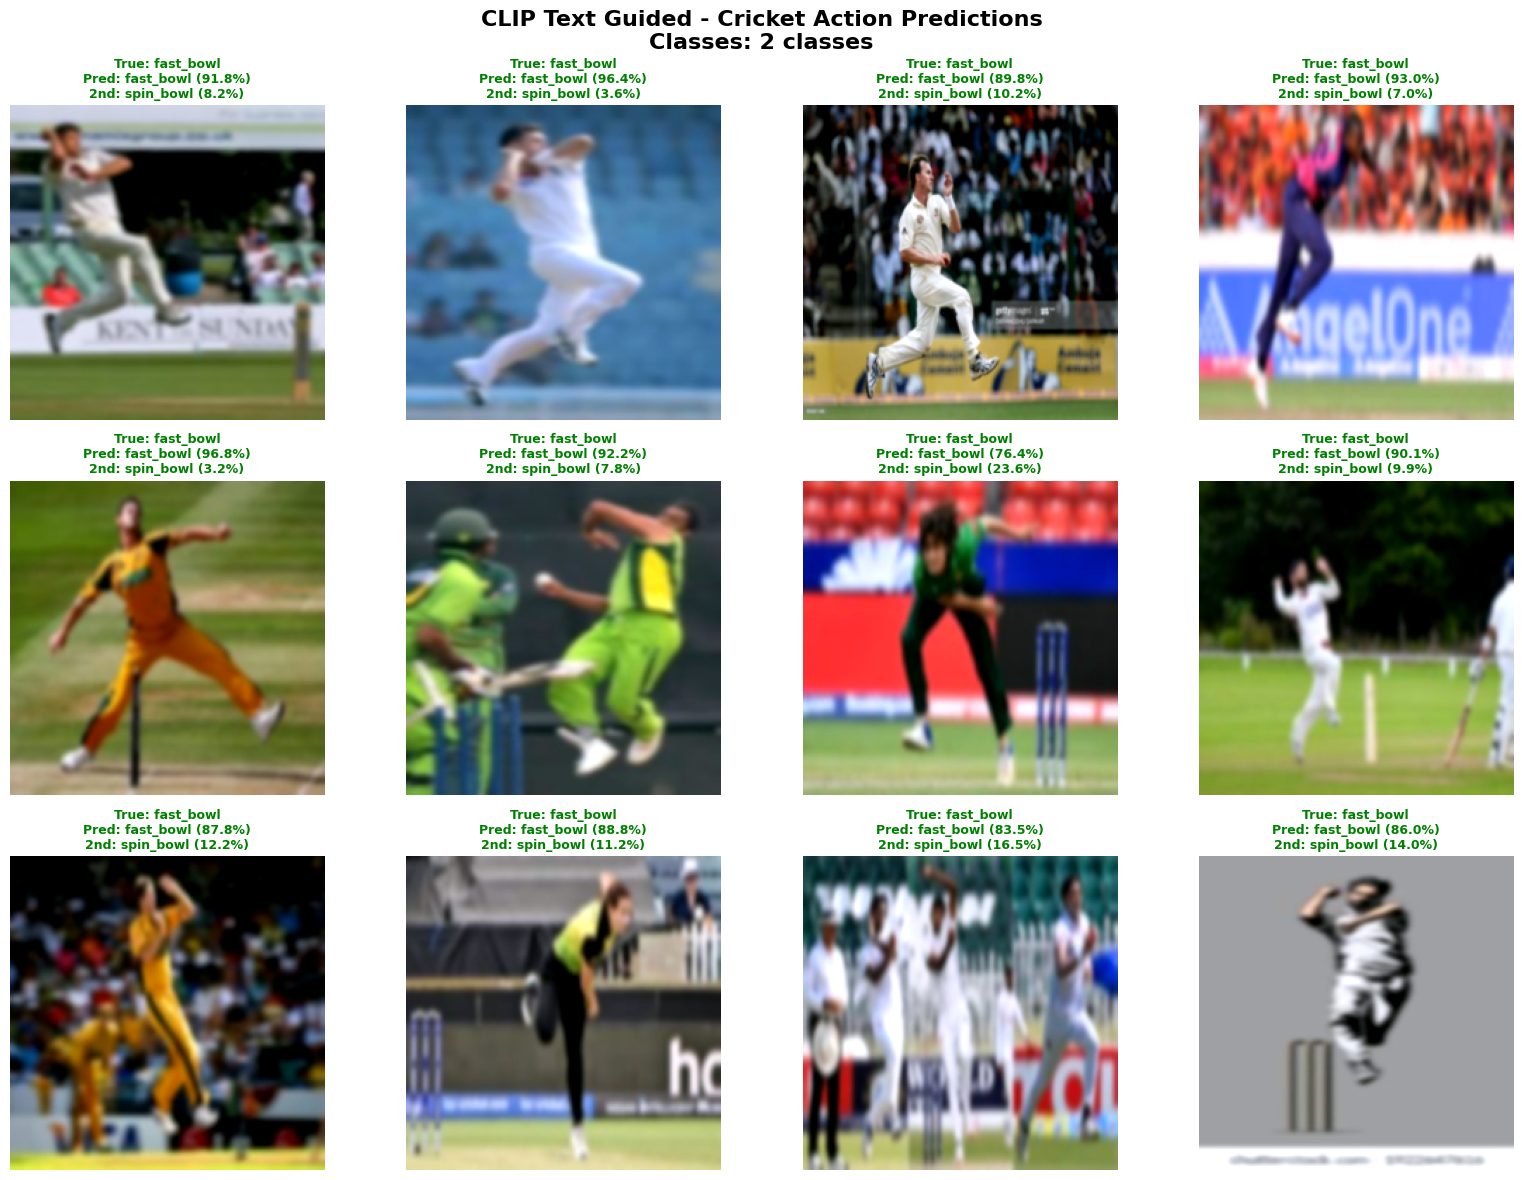

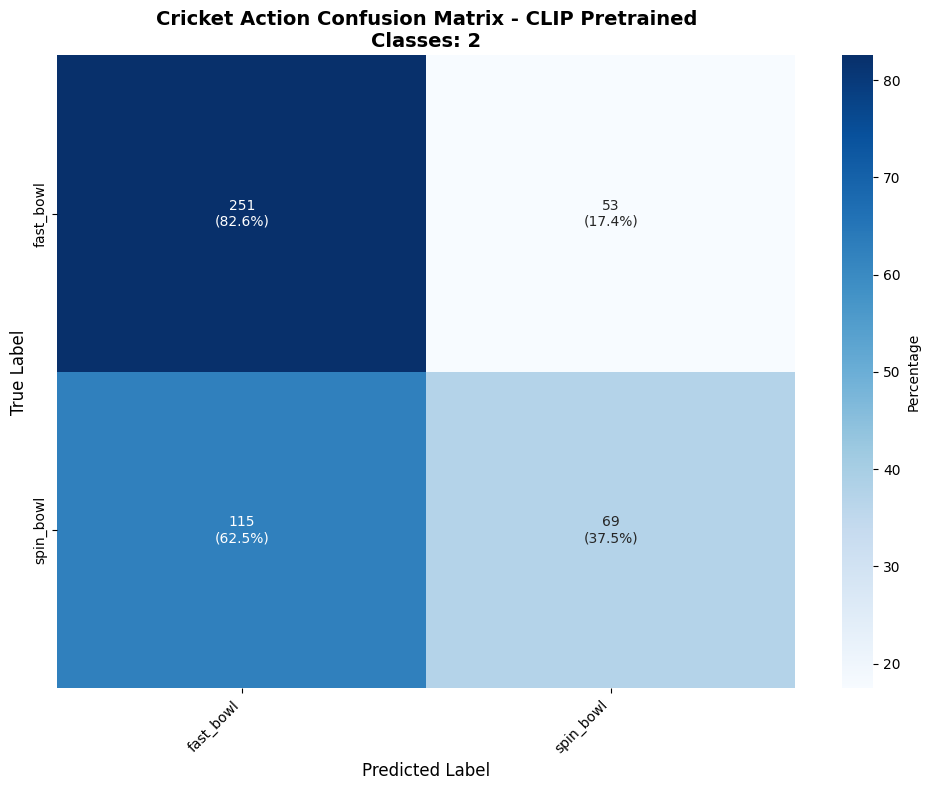


3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
🚀 Training ViT Text Supervised with Text Supervision...

📅 Epoch 1/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.60it/s, Loss=0.6826, Acc=58.95%]


✅ Best validation accuracy: 56.77%
📊 Train Acc: 58.95% | Val Acc: 56.77%

📅 Epoch 2/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6601, Acc=60.59%]


✅ Best validation accuracy: 59.11%
📊 Train Acc: 60.59% | Val Acc: 59.11%

📅 Epoch 3/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.6436, Acc=59.80%]


✅ Best validation accuracy: 62.50%
📊 Train Acc: 59.80% | Val Acc: 62.50%

📅 Epoch 4/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6621, Acc=61.84%]


📊 Train Acc: 61.84% | Val Acc: 62.50%

📅 Epoch 5/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.6657, Acc=62.11%]


📊 Train Acc: 62.11% | Val Acc: 45.31%

📅 Epoch 6/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6524, Acc=62.24%]


📊 Train Acc: 62.24% | Val Acc: 46.88%

📅 Epoch 7/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, Loss=0.6374, Acc=60.00%]


📊 Train Acc: 60.00% | Val Acc: 62.50%

📅 Epoch 8/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6411, Acc=62.04%]


📊 Train Acc: 62.04% | Val Acc: 62.50%

📅 Epoch 9/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6494, Acc=62.50%]


📊 Train Acc: 62.50% | Val Acc: 62.50%

📅 Epoch 10/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6316, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 11/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6325, Acc=62.83%]


📊 Train Acc: 62.83% | Val Acc: 62.50%

📅 Epoch 12/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, Loss=0.6318, Acc=63.03%]


📊 Train Acc: 63.03% | Val Acc: 39.58%

📅 Epoch 13/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6455, Acc=63.36%]


📊 Train Acc: 63.36% | Val Acc: 62.50%

📅 Epoch 14/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s, Loss=0.6684, Acc=61.12%]


📊 Train Acc: 61.12% | Val Acc: 62.50%

📅 Epoch 15/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6701, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 16/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6679, Acc=62.50%]


📊 Train Acc: 62.50% | Val Acc: 62.50%

📅 Epoch 17/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, Loss=0.6710, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 18/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6684, Acc=62.57%]


📊 Train Acc: 62.57% | Val Acc: 62.50%

📅 Epoch 19/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6700, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 20/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, Loss=0.6681, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 21/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, Loss=0.6690, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 22/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6676, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 23/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6687, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 24/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6713, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 25/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6698, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 26/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6676, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 27/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6691, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 28/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6689, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 29/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6687, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 30/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6685, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 31/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6682, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 32/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6685, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 33/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6671, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 34/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6674, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 35/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6690, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 36/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s, Loss=0.6682, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 37/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6676, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 38/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6674, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 39/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6684, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 40/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6688, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 41/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6685, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 42/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6668, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 43/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6655, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 44/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6672, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 45/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6679, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 46/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6664, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 47/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6687, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 48/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6668, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 49/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.6675, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%

📅 Epoch 50/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6677, Acc=62.63%]


📊 Train Acc: 62.63% | Val Acc: 62.50%
✅ Loaded best_vit_text_supervised.pth for evaluation

🔍 Evaluating ViT Text Supervised...
📋 Classes: 2 classes


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


🎯 ViT Text Supervised Accuracy: 0.6148 (61.48%)
📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl     0.6229    0.9671    0.7577       304
   spin_bowl     0.3750    0.0326    0.0600       184

    accuracy                         0.6148       488
   macro avg     0.4989    0.4999    0.4089       488
weighted avg     0.5294    0.6148    0.4947       488



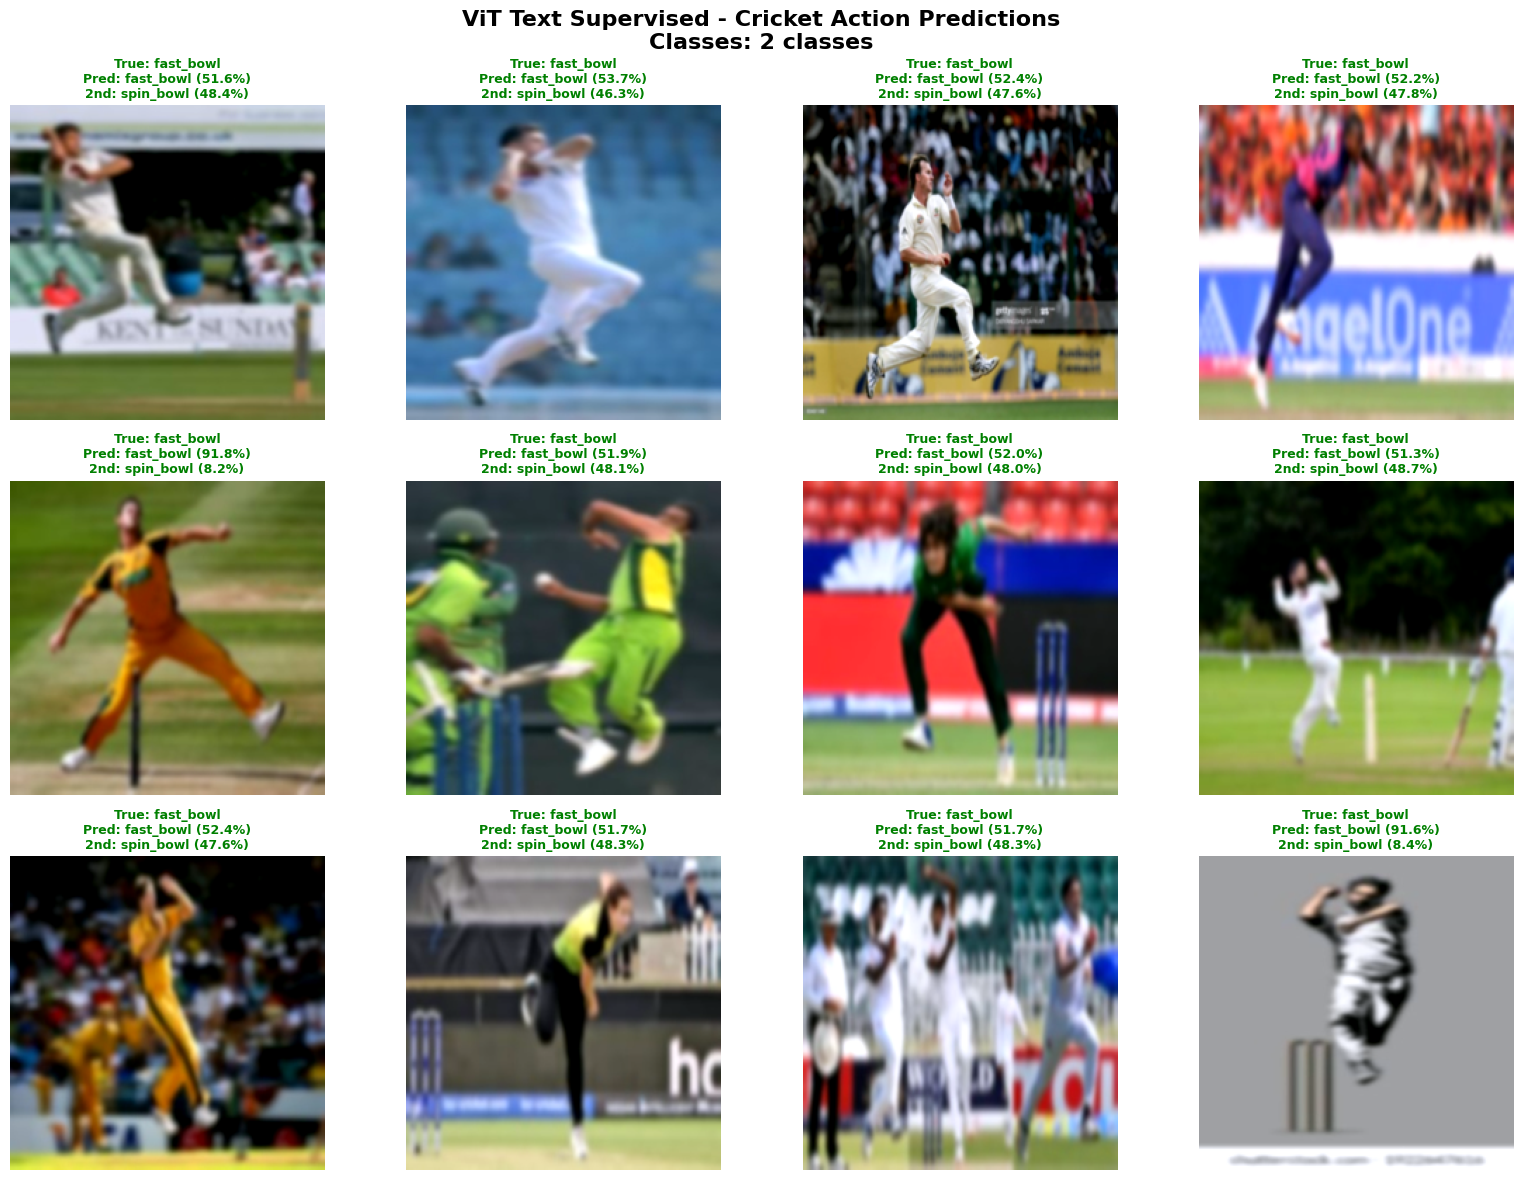

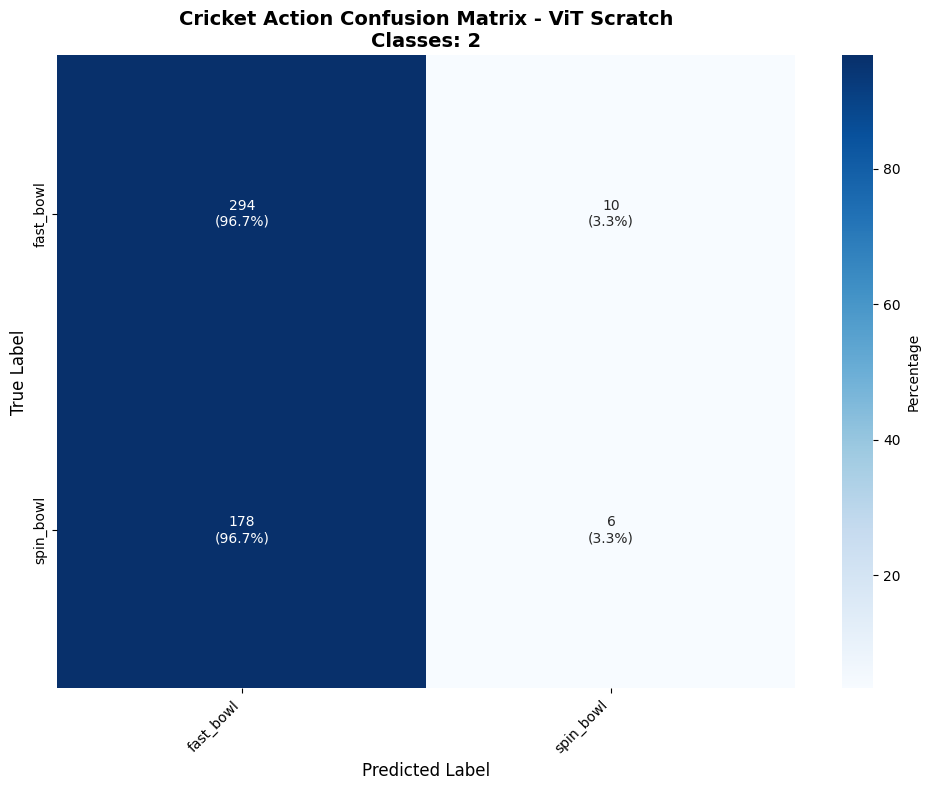


📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)


/tmp/ipykernel_19/2066667471.py:811: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


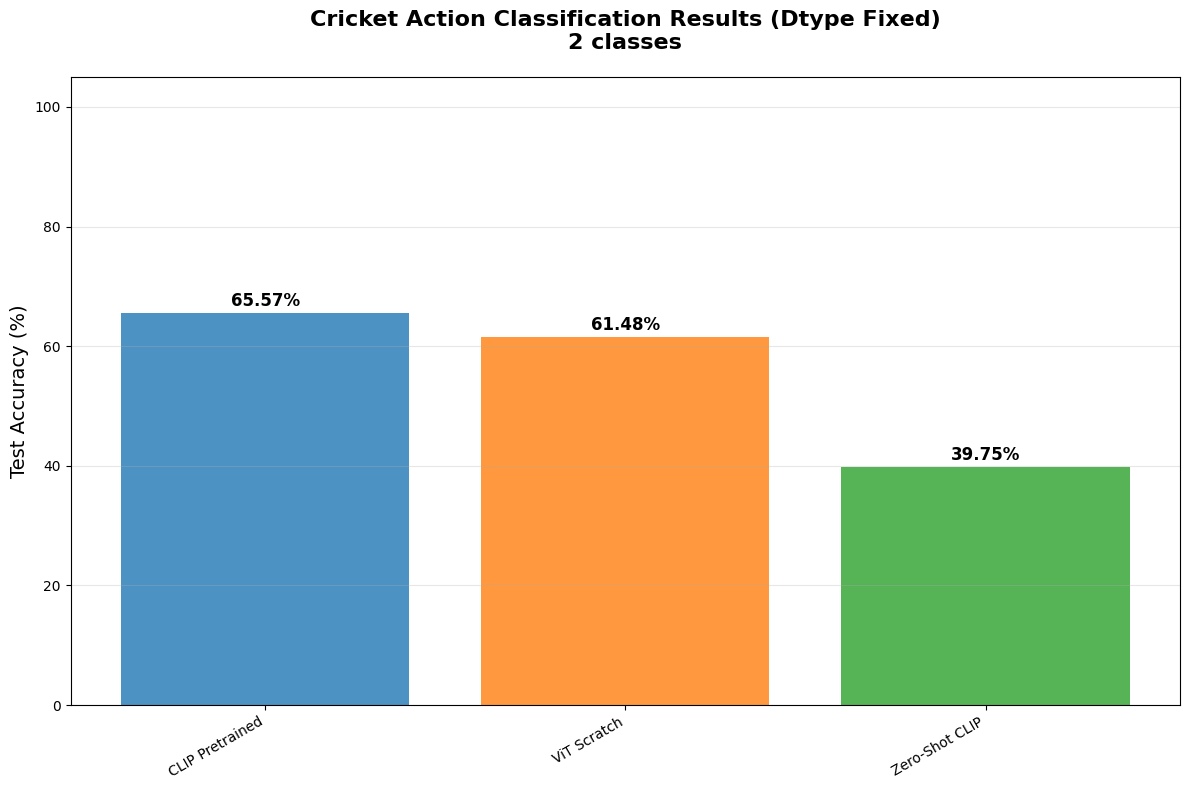

🏆 FINAL RANKINGS:
🥇 CLIP Pretrained: 0.6557 (65.57%)
🥈 ViT Scratch: 0.6148 (61.48%)
🥉 Zero-Shot CLIP: 0.3975 (39.75%)

📈 Performance Range: 64.95% improvement from worst to best

✨ TEXT ENHANCEMENT BENEFITS:
│ 🎯 Semantic Understanding: Models learn explicit action descriptions
│ 🔄 Multi-Modal Learning: Combines visual and textual information
│ 📈 Better Generalization: Text guidance improves robustness
│ 🎨 Interpretability: Clear text-image associations
│ 🚀 Faster Convergence: Text supervision accelerates learning

✅ Cricket Action Classification Complete (DType Fixed)!
🔧 All dtype mismatches resolved
📋 Classes processed: 2
📁 Generated Files (examples):
│ zero-shot_clip_cricket_predictions.png
│ clip_text_guided_cricket_predictions.png
│ vit_text_supervised_cricket_predictions.png
│ zero-shot_clip_confusion_matrix.png
│ clip_pretrained_confusion_matrix.png
│ vit_scratch_confusion_matrix.png
│ cricket_action_final_results_fixed.png


In [9]:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)